# DataJoint Elements for Optogenetics

#### Open-source data pipeline for processing and analyzing optogenetics datasets.

Welcome to the tutorial for the DataJoint Element for optogenetics. This
tutorial aims to provide a comprehensive understanding of the open-source data pipeline
created using `element-optogenetics`.

This package is designed to seamlessly ingest and track optogenetics data. By the end of this
tutorial you will have a clear grasp on setting up and integrating `element-optogenetics`
into your specific research projects and lab. 

![flowchart](../images/diagram_flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject, session, surgery metadata.
+ *Insert* optogenetics recording data.
+ Query and view data

### **Setup**

This tutorial examines DataJoint tables that track optogenetics data. The goal is to store, track
and manage all metadata associated with optogenetics experiments, including surgical
implanation data. 

The results of this Element can be combined with **other modalities** to create
a complete, customizable data pipeline for your specific lab or study. For instance, you
can combine `element-optogenetics` with `element-array-ephys` and
`element-event` to characterize the neural activity during specific optogenetic stimulus
events.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
Let's connect to the database server.

In [2]:
dj.conn()

[2024-01-04 20:00:17,037][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-04 20:00:17,044][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `optogenetics.py` module from `element-optogenetics`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

In [3]:
from tutorial_pipeline import lab, subject, surgery, session, optogenetics, Device

[2024-01-04 20:00:18,332][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `optogenetics` schemas as well as some of the
upstream dependencies to `session` and `subject` schemas as a diagram.

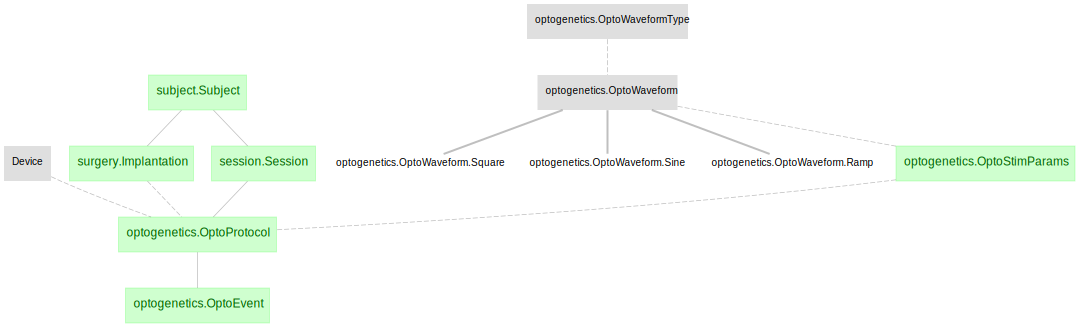

In [5]:
(
    dj.Diagram(subject.Subject) + dj.Diagram(surgery.Implantation)
    + dj.Diagram(session.Session) + dj.Diagram(Device) + dj.Diagram(optogenetics)
)

As evident from the diagram, this data pipeline encompasses tables associated with
recording and probe metadata, results of clustering, and optional curation of clustering
results. A few tables, such as `subject.Subject` or `session.Session`,
while important for a complete pipeline, fall outside the scope of the `element-optogenetics`
tutorial, and will therefore, not be explored extensively here. The primary focus of
this tutorial will be on the `optogenetics` schemas.

### **Insert subject, surgery, and session metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` methods.

In [ ]:
subject.Subject()

In [ ]:
print(subject.Subject.describe())

In [ ]:
subject.Subject.heading

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [ ]:
subject.Subject.insert1(
    dict(subject="subject1", subject_birth_date="2023-01-01", sex="U")
)
subject.Subject()

Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`.

In [ ]:
print(session.Session.describe())

In [ ]:
session.Session.heading

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [ ]:
session_key = dict(subject="subject5", session_datetime="2023-01-01 00:00:00")

In [ ]:
session.Session.insert1(session_key)
session.Session()

Every experimental session produces a set of data files. The purpose of the `SessionDirectory` table is to locate these files. It references a directory path relative to a root directory, defined in `dj.config["custom"]`. More information about `dj.config` is provided in the [documentation](https://datajoint.com/docs/elements/user-guide/).

In [ ]:
session.SessionDirectory.insert1(
    dict(**session_key, session_dir="raw/subject5/session1")
)
session.SessionDirectory()

As the Diagram indicates, the tables in the `probe` schemas need to
contain data before the tables in the `ephys` schema accept any data. Let's
start by inserting into `probe.Probe`, a table containing metadata about a
multielectrode probe. 

In [ ]:
Device.insert1(
    dict(
        device="OPTG_8",
        modality="Optogenetics",
        description="8 channel pulse sequence device",
    )
)
Device()

In [ ]:
lab.User.insert1(dict(user="User1"))
lab.User()

The probe metadata is used by the downstream `ProbeInsertion` table which we
insert data into in the cells below:

In [ ]:
surgery.CoordinateReference()

In [ ]:
surgery.Hemisphere()

In [ ]:
surgery.BrainRegion.insert1(
    dict(region_acronym="dHP", region_name="Dorsal Hippocampus")
)
surgery.BrainRegion()

In [ ]:
surgery.Implantation.insert1(
    dict(
        subject="subject1",
        implant_date="2022-04-01 12:13:14",
        implate_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        surgeon="User1",
    )
)

surgery.Implantation.Coordinate.insert1(
    dict(
        subject="subject1",
        implant_date="2022-04-01 12:13:14",
        implate_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        ap="-7.9",
        ap_ref="bregma",
        ml="-1.8",
        ml_ref="bregma",
        dv="5",
        dv_ref="skull_surface",
        theta="11.5",
        phi="0",
        beta=None,
    )
)

Confirm the inserted information:

In [ ]:
surgery.Implantation()

In [ ]:
surgery.Implantation.Coordinate()

In [ ]:
optogenetics.OptoWaveform.insert1(
    dict(
        waveform_name="square_10",
        waveform_type="square",
        waveform_description="Square waveform: 10%/90% on/off cycle",
    )
)

# Square is one part table of OptoWaveform.
# For sine and ramp waveforms, see the corresponding tables.
optogenetics.OptoWaveform.Square.insert1(
    dict(waveform_name="square_10", on_proportion=0.10, off_proportion=0.90)
)

In [ ]:
optogenetics.OptoStimParams.insert1(
    dict(
        opto_params_id=1,
        waveform_name="square_10",
        wavelength=470,
        light_intensity=10.2,
        frequency=1,
        duration=241,
    )
)

### **Populate electrophysiology recording metadata**

In the upcoming cells, the `.populate()` method will automatically extract and store the
recording metadata for each experimental session in the `ephys.EphysRecording` table and its part table `ephys.EphysRecording.EphysFile`.

In [ ]:
ephys.EphysRecording()

In [ ]:
ephys.EphysRecording.EphysFile()

In [ ]:
ephys.EphysRecording.populate(session_key, display_progress=True)

Let's view the information was entered into each of these tables:

In [ ]:
ephys.EphysRecording()

In [ ]:
ephys.EphysRecording.EphysFile()

### **Run the Clustering Task**

We're almost ready to spike sort the data with `kilosort`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
define the kilosort parameters in a dictionary and insert them into a DataJoint table
`ClusteringParamSet`. This table keeps track of all combinations of your spike sorting
parameters. You can choose which parameters are used during processing in a later step.

Let's view the attributes and insert data into `ephys.ClusteringParamSet`.

In [ ]:
ephys.ClusteringParamSet.heading

In [ ]:
# insert clustering task manually
params_ks = {
    "fs": 30000,
    "fshigh": 150,
    "minfr_goodchannels": 0.1,
    "Th": [10, 4],
    "lam": 10,
    "AUCsplit": 0.9,
    "minFR": 0.02,
    "momentum": [20, 400],
    "sigmaMask": 30,
    "ThPr": 8,
    "spkTh": -6,
    "reorder": 1,
    "nskip": 25,
    "GPU": 1,
    "Nfilt": 1024,
    "nfilt_factor": 4,
    "ntbuff": 64,
    "whiteningRange": 32,
    "nSkipCov": 25,
    "scaleproc": 200,
    "nPCs": 3,
    "useRAM": 0,
}
ephys.ClusteringParamSet.insert_new_params(
    clustering_method="kilosort2",
    paramset_idx=0,
    params=params_ks,
    paramset_desc="Spike sorting using Kilosort2",
)
ephys.ClusteringParamSet()

DataJoint uses a `ClusteringTask` table to
manage which `EphysRecording` and `ClusteringParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [ ]:
ephys.ClusteringTask.heading

The `ClusteringTask` table contains two important attributes: 
+ `paramset_idx` - Allows the user to choose the parameter set with which you want to
  run spike sorting.
+ `task_mode` - Can be set to `load` or `trigger`. When set to `load`, running the
  Clustering step initiates a search for existing output files of the spike sorting
  algorithm defined in `ClusteringParamSet`. When set to `trigger`, the processing step
  will run spike sorting on the raw data.

In [ ]:
ephys.ClusteringTask.insert1(
    dict(
        session_key,
        insertion_number=1,
        paramset_idx=0,
        task_mode="load",  # load or trigger
        clustering_output_dir="processed/subject5/session1/probe_1/kilosort2-5_1",
    )
)

Let's call populate on the `Clustering` table which checks for kilosort results since `task_mode=load`.

In [ ]:
ephys.Clustering.populate(session_key, display_progress=True)

### **Curate the results (Optional)**

While spike sorting is completed in the above step, you can optionally curate
the output of image processing using the `Curation` table. For this demo, we
will simply use the results of the spike sorting output from the `Clustering` task.

In [ ]:
ephys.Curation.heading

In [ ]:
clustering_key = (ephys.ClusteringTask & session_key).fetch1("KEY")
ephys.Curation().create1_from_clustering_task(clustering_key)

Once the `Curation` table receives an entry, we can populate the remaining
tables in the workflow including `CuratedClustering`, `WaveformSet`, and `LFP`. 

In [ ]:
ephys.CuratedClustering.populate(session_key, display_progress=True)
ephys.LFP.populate(session_key, display_progress=True)
ephys.WaveformSet.populate(session_key, display_progress=True)

Now that we've populated the tables in this DataJoint pipeline, there are one of
several next steps. If you have an existing pipeline for
aligning waveforms to behavior data or other stimuli, you can easily
invoke `element-event` or define your custom DataJoint tables to extend the
pipeline.

### **Visualize the results**

In this tutorial, we will do some exploratory analysis by fetching the data from the database and creating a few plots.

In [ ]:
lfp_average = (ephys.LFP & "insertion_number = '1'").fetch1("lfp_mean")

In the query above, we fetch a single `lfp_mean` attribute from the `LFP` table.
We also restrict the query to insertion number 1.

Let's go ahead and plot the LFP mean.

In [ ]:
plt.plot(lfp_average)
plt.title("Average LFP Waveform for Insertion 1")
plt.xlabel("Samples")
plt.ylabel("microvolts (uV)");

DataJoint queries are a highly flexible tool to manipulate and visualize your data.
After all, visualizing traces or generating rasters is likely just the start of
your analysis workflow. This can also make the queries seem more complex at
first. However, we'll walk through them slowly to simplify their content in this notebook. 

The examples below perform several operations using DataJoint queries:
- Fetch the primary key attributes of all units that are in `insertion_number=1`.
- Use **multiple restrictions** to fetch timestamps and create a raster plot.
- Use a **join** operation and **multiple restrictions** to fetch a waveform
  trace, along with unit data to create a single waveform plot

In [ ]:
insert_key = (ephys.ProbeInsertion & "insertion_number = '1'").fetch1("KEY")
units, unit_spiketimes = (
    ephys.CuratedClustering.Unit
    & insert_key
    & 'unit IN ("6","7","9","14","15","17","19")'
).fetch("unit", "spike_times")

In [ ]:
x = np.hstack(unit_spiketimes)
y = np.hstack([np.full_like(s, u) for u, s in zip(units, unit_spiketimes)])
plt.plot(x, y, "|")
plt.xlabel("Time (s)")
plt.ylabel("Unit");

Below we will use two queries to fetch *all* of the information about a single unit and
plot the unit waveform.

In [ ]:
unit_key = (ephys.CuratedClustering.Unit & insert_key & "unit = '15'").fetch1("KEY")
unit_data = (
    ephys.CuratedClustering.Unit * ephys.WaveformSet.PeakWaveform & unit_key
).fetch1()

In [ ]:
unit_data

In [ ]:
sampling_rate = (ephys.EphysRecording & insert_key).fetch1(
    "sampling_rate"
) / 1000  # in kHz
plt.plot(
    np.r_[: unit_data["peak_electrode_waveform"].size] * 1 / sampling_rate,
    unit_data["peak_electrode_waveform"],
)
plt.xlabel("Time (ms)")
plt.ylabel(r"Voltage ($\mu$V)");

## Summary

Following this tutorial, we have: 
+ Covered the essential functionality of `element-array-ephys`.
+ Learned how to manually insert data into tables.
+ Executed and ingested results of spike sorting with Kilosort.
+ Visualized the results. 

#### Documentation and DataJoint Tutorials

+ [Detailed documentation on
  `element-array-ephys`.](https://datajoint.com/docs/elements/element-array-ephys/)
+ [General `datajoint-python`
  tutorials.](https://github.com/datajoint/datajoint-tutorials) covering fundamentals,
  such as table tiers, query operations, fetch operations, automated computations with the
  make function, and more.
+ [Documentation for
  `datajoint-python`.](https://datajoint.com/docs/core/datajoint-python/)

##### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:
+ Download the [mysql-docker image for
  DataJoint](https://github.com/datajoint/mysql-docker) and run the container according
  to the instructions provide in the repository.
+ Create a fork of this repository to your GitHub account.
+ Clone the repository and open the files using your IDE.
+ Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

+ Run the code block above and proceed with the rest of the notebook.